# Industry exploration

## LDA model

In [30]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import TSNE

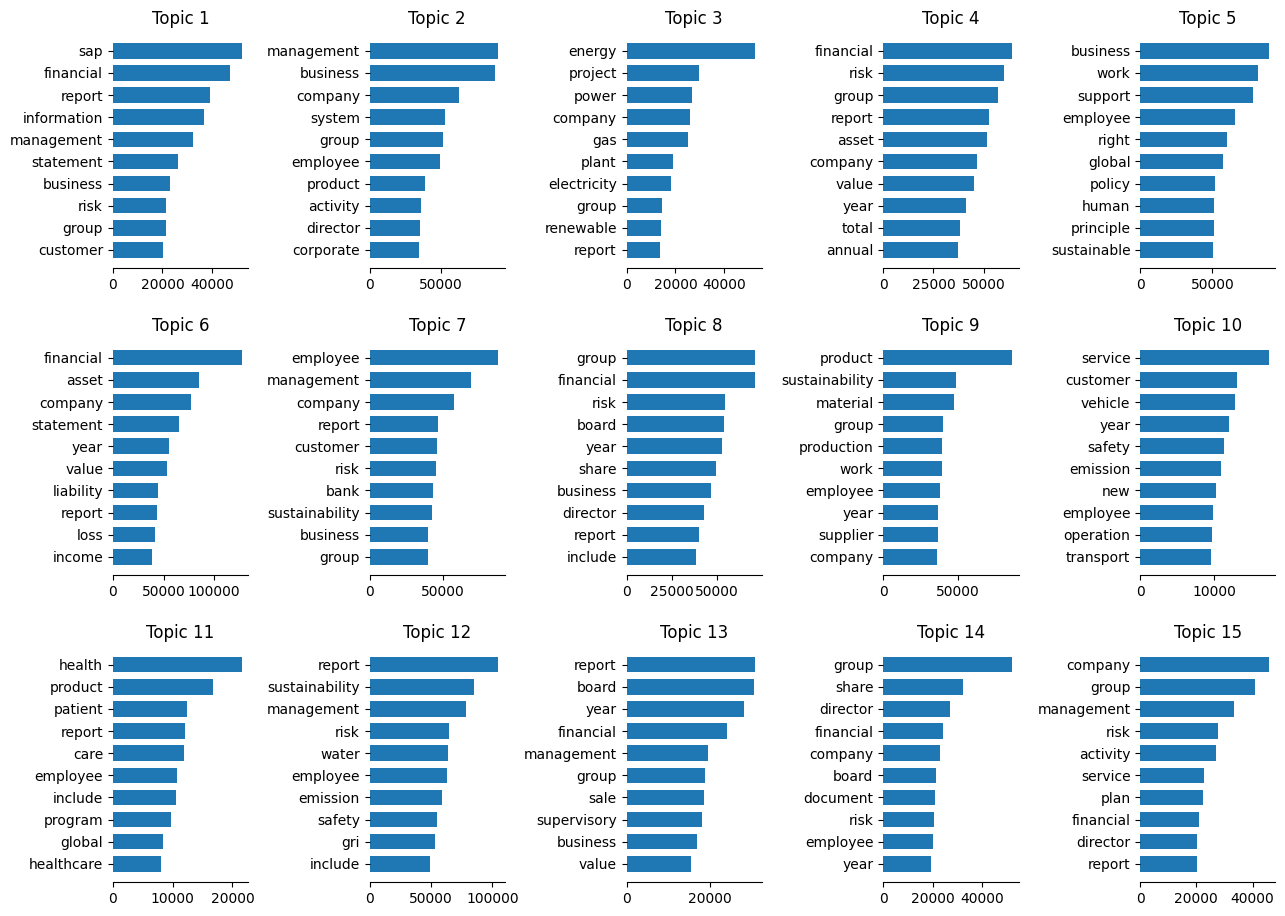

In [31]:
sys.path.append("../code")
from exploration import DataExploration
exploration = DataExploration().load_data()
exploration = exploration.construct_lda(n_topics=15)
exploration.plot_lda_top_words(figsize=(15,10));

## Simple comparison

In [32]:
exploration.data.sector.value_counts().head(10)

sector
Not Applicable                  1045
Diversified                      587
Industrial Support Services      412
Software & Computer Services     333
General Industrials              293
Finance and credit services      266
Food Producers                   195
Chemicals                        177
Construction & Materials         176
Retailers                        158
Name: count, dtype: int64

In [33]:
doc_topic_distribution = pd.DataFrame(exploration.lda_model.transform(exploration.tf_data))
n_topics = doc_topic_distribution.shape[1]
doc_topic_distribution.columns = ["topic_{}".format(i) for i in range(1, n_topics + 1)]
doc_topic_distribution["sector"] = exploration.data.sector.reset_index(drop=True)
doc_topic_distribution["country"] = exploration.data.country.reset_index(drop=True)

# sector
sector_columns = ["sector"] + ["topic_{}".format(i) for i in range(1, n_topics + 1)]
sector_topic_distribution = doc_topic_distribution.loc[:,sector_columns].groupby("sector", as_index=False).median()
sector_topic_distribution = sector_topic_distribution\
    .merge(exploration.data.sector.value_counts(), on="sector").rename(columns={"count":"n_docs"})\
    .sort_values("n_docs", ascending=False).reset_index(drop=True)

# country
country_columns = ["country"] + ["topic_{}".format(i) for i in range(1, n_topics + 1)]
country_topic_distribution = doc_topic_distribution.loc[:,country_columns].groupby("country", as_index=False).median()
country_topic_distribution = country_topic_distribution\
    .merge(exploration.data.country.value_counts(), on="country").rename(columns={"count":"n_docs"})\
    .sort_values("n_docs", ascending=False).reset_index(drop=True)

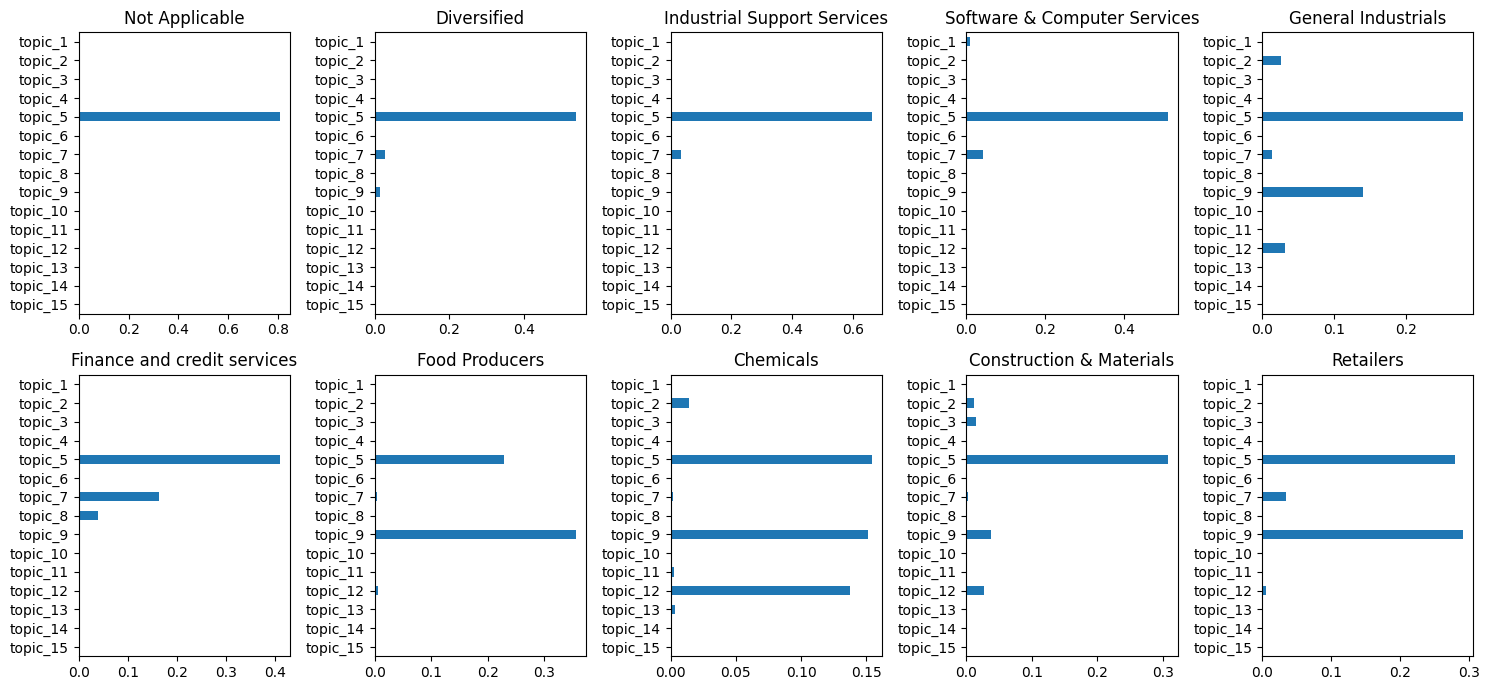

In [34]:
f, axs = plt.subplots(2, 5, figsize=(15, 7))
axs_flat = axs.flatten()
for i, r in sector_topic_distribution\
    .head(10).iterrows():
    sector = r["sector"]
    row_data = r.filter(regex="topic_")
    row_data.plot(kind="barh", ax=axs_flat[i])
    axs_flat[i].invert_yaxis()
    axs_flat[i].set_title(sector)
plt.tight_layout()

## Industry similarity

### Hierarchical tree

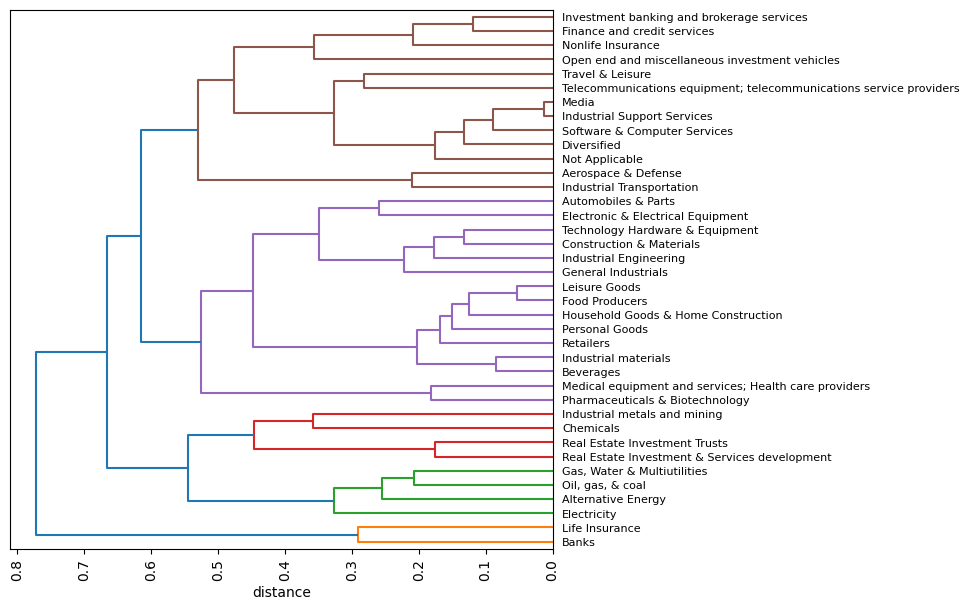

In [35]:
linkage_matrix = linkage(sector_topic_distribution.filter(regex="topic_"),
    method="complete", metric="jensenshannon")
f = plt.figure(figsize=(7, 7))
dendrogram(linkage_matrix, labels=sector_topic_distribution["sector"].tolist(), orientation="left")
plt.xlabel("distance")
plt.xticks(rotation="vertical")
plt.show()

### Jensen-Shannon Divergence

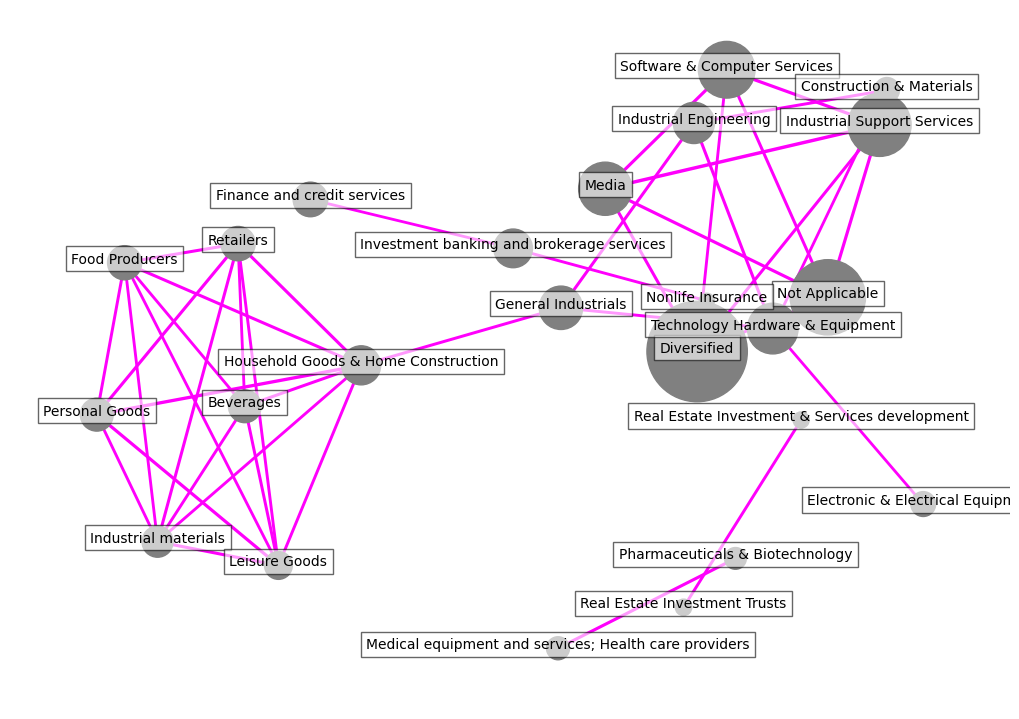

In [36]:
# jsd graph
corr_mat = sector_topic_distribution.filter(regex="topic_").transpose().corr(method=jensenshannon)
edges = pd.melt(corr_mat.reset_index(), id_vars="index")\
    .rename(columns={"index":"from", "variable":"to", "value":"jsd"})
edges = edges.loc[edges["from"] > edges["to"]]
edges["jsd"] = 1-edges["jsd"]
edges = edges.loc[edges["jsd"] >= 0.8]

nodes = sector_topic_distribution.loc[:, ["sector", "n_docs"]].rename(columns={"sector":"id"})
nodes = nodes.loc[nodes.index.isin(set(edges["from"]).union(set(edges["to"]))), :]

G = nx.from_pandas_edgelist(edges, source="from", target="to", edge_attr="jsd")
pos = nx.kamada_kawai_layout(G, weight="jsd")
#edge_colors = ["#ff00fc" if w > 0.5 else "#0c70fa" for w in edges["jsd"]]
f = plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=nodes["n_docs"]*5, node_color="gray",
    with_labels=False, font_size=10, width=edges["jsd"].abs()*2.5,
    edge_color="#ff00fc")
nx.draw_networkx_labels(G, pos, labels=nodes.id, font_size=10,
    bbox=dict(facecolor="white", alpha=0.6),
    verticalalignment="baseline")
plt.show()

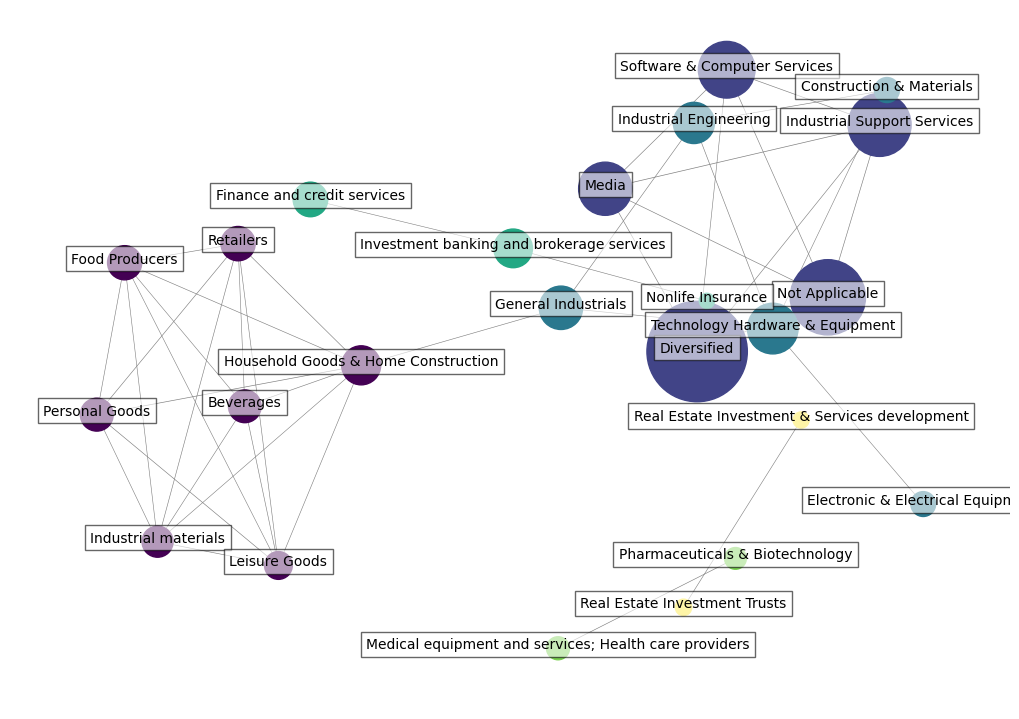

In [37]:
# communities in jsd graph
c = nx.community.greedy_modularity_communities(G, weight="jsd", cutoff=3)
cmap = plt.get_cmap("viridis", len(c))
node_colors = {n:i for i,subset in enumerate(c) for n in subset}
node_colors = [node_colors[n] for n in G.nodes()]
pos = nx.kamada_kawai_layout(G, weight="jsd")
f = plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=nodes["n_docs"]*5, node_color=node_colors,
    with_labels=False, font_size=10, width=edges["jsd"].abs()*0.5,
    edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=nodes.id, font_size=10,
    bbox=dict(facecolor="white", alpha=0.6),
    verticalalignment="baseline")
plt.show()

## Document similarity

### Manifold

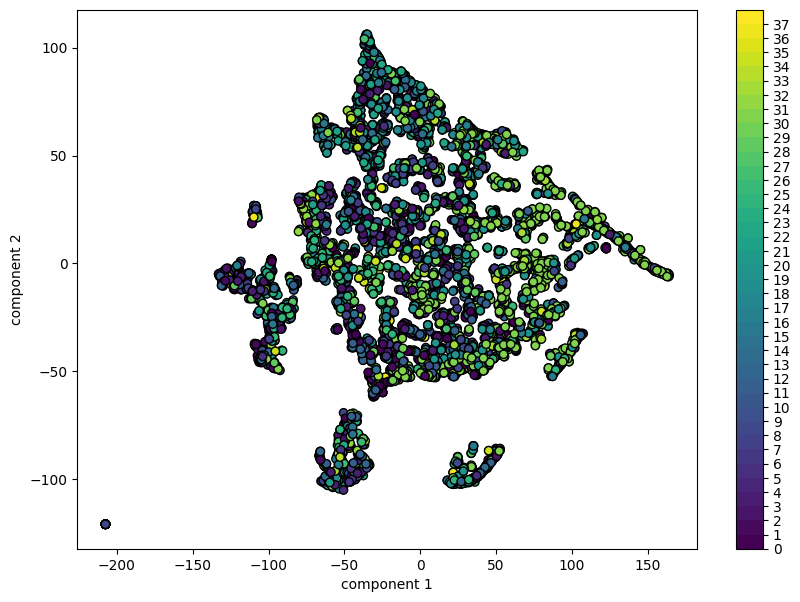

In [38]:
tsne = TSNE(n_components=2, random_state=42, perplexity=25, learning_rate=100, n_iter=5000)
tsne_data = tsne.fit_transform(doc_topic_distribution.filter(regex="topic_"))
tsne_data = pd.DataFrame(tsne_data, columns=["x", "y"])
tsne_data["sector"] = exploration.data.sector.reset_index(drop=True)

# discrete cmap
num_sectors = tsne_data["sector"].nunique()
cmap = plt.get_cmap("viridis", num_sectors)
label_dict = {label:i for i, label in enumerate(tsne_data["sector"].unique())}

plt.figure(figsize=(10, 7))
plt.scatter(tsne_data["x"], tsne_data["y"],
    c=tsne_data["sector"].map(label_dict).values,
    cmap=cmap, edgecolors="black")
plt.colorbar(ticks=range(num_sectors), label="")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.show()

### Hierarchical tree

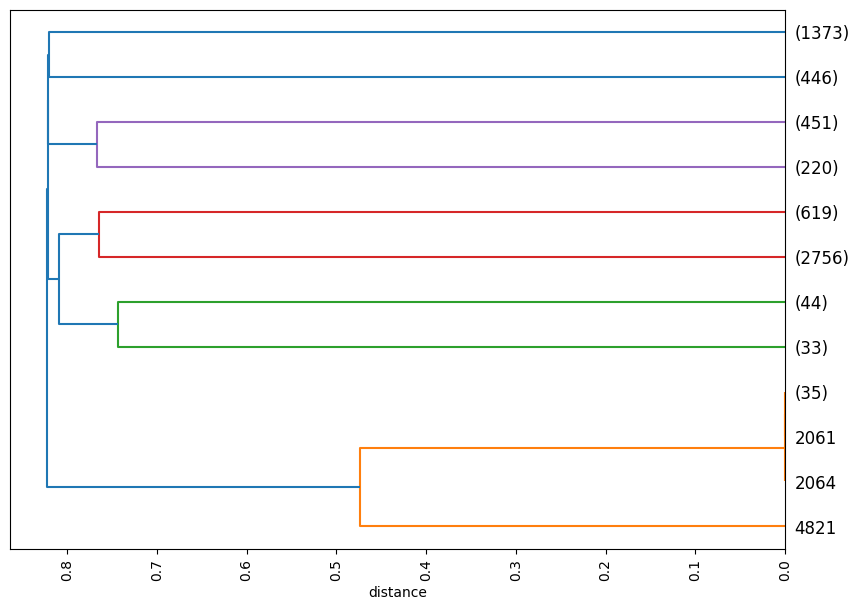

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(np.round(doc_topic_distribution.filter(regex="topic_"),3)+0.001,
    method="complete", metric="jensenshannon")
f = plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode="level",
    p=3, color_threshold=0.8, orientation="left",
    show_leaf_counts=True)
plt.xlabel("distance")
plt.xticks(rotation="vertical")
plt.show()

### Jensen-Shannon Divergence

In [40]:
corr_mat = doc_topic_distribution.filter(regex="topic_").transpose().corr(method=jensenshannon)
edges = pd.melt(corr_mat.reset_index(), id_vars="index")\
    .rename(columns={"index":"from", "variable":"to", "value":"jsd"})
edges = edges.loc[edges["from"] > edges["to"]]
edges["jsd"] = 1-edges["jsd"]

/mnt/Data/git_root/sustainability-reports-industry-analysis/.env/lib/python3.10/site-packages/scipy/spatial/distance.py:1259: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [41]:
edges_ = edges.copy()
edges = edges.loc[edges["jsd"] >= 0.8]

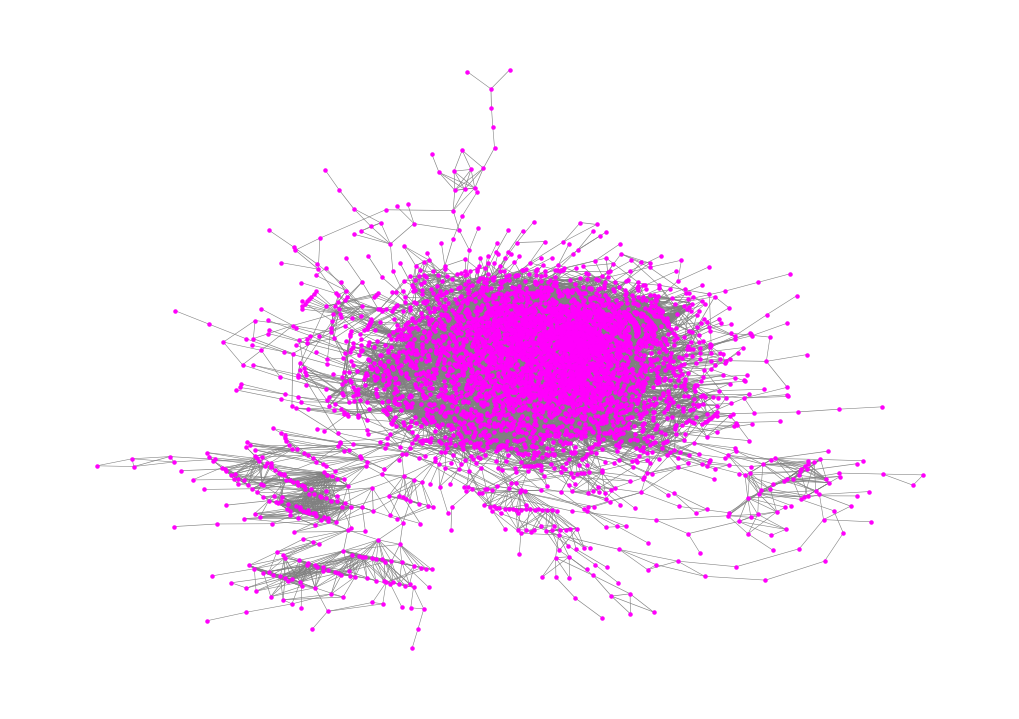

In [42]:
# jsd graph
#corr_mat = doc_topic_distribution.filter(regex="topic_").transpose().corr(method=jensenshannon)
#edges = pd.melt(corr_mat.reset_index(), id_vars="index")\
#    .rename(columns={"index":"from", "variable":"to", "value":"jsd"})
#edges = edges.loc[edges["from"] > edges["to"]]
#edges["jsd"] = 1-edges["jsd"]
#edges = edges.loc[edges["jsd"] < 0.6]

nodes = doc_topic_distribution.loc[:, ["sector"]].rename(columns={"sector":"id"})
nodes = nodes.loc[nodes.index.isin(set(edges["from"]).union(set(edges["to"]))), :]

G = nx.from_pandas_edgelist(edges, source="from", target="to", edge_attr="jsd")
pos = nx.kamada_kawai_layout(G, weight="jsd")
f = plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=5, node_color="#ff00fc",
    with_labels=False, font_size=10, width=edges["jsd"].abs()*0.5,
    edge_color="gray")
plt.show()

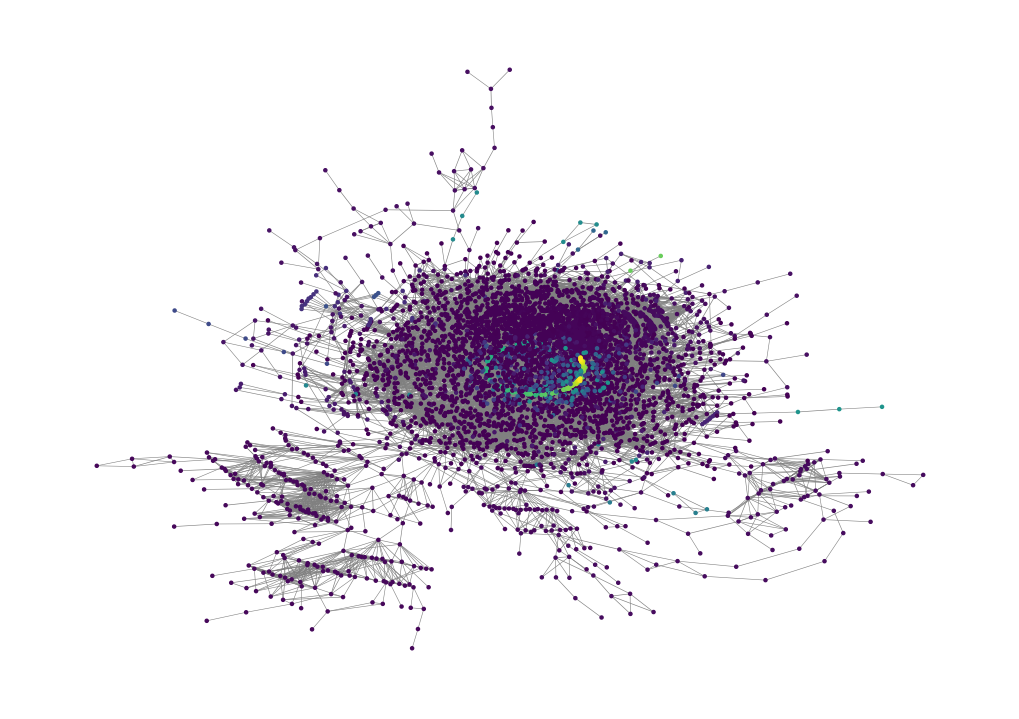

In [43]:
# communities in jsd graph
c = nx.community.greedy_modularity_communities(G, weight="jsd", cutoff=5)
cmap = plt.get_cmap("viridis", len(c))
node_colors = {n:i for i,subset in enumerate(c) for n in subset}
node_colors = [node_colors[n] for n in G.nodes()]
#pos = nx.kamada_kawai_layout(G, weight="jsd")
f = plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=5, node_color=node_colors,
    with_labels=False, font_size=10, width=edges["jsd"].abs()*0.5,
    edge_color="gray")
plt.show()

## Countries

### Hierarchical tree

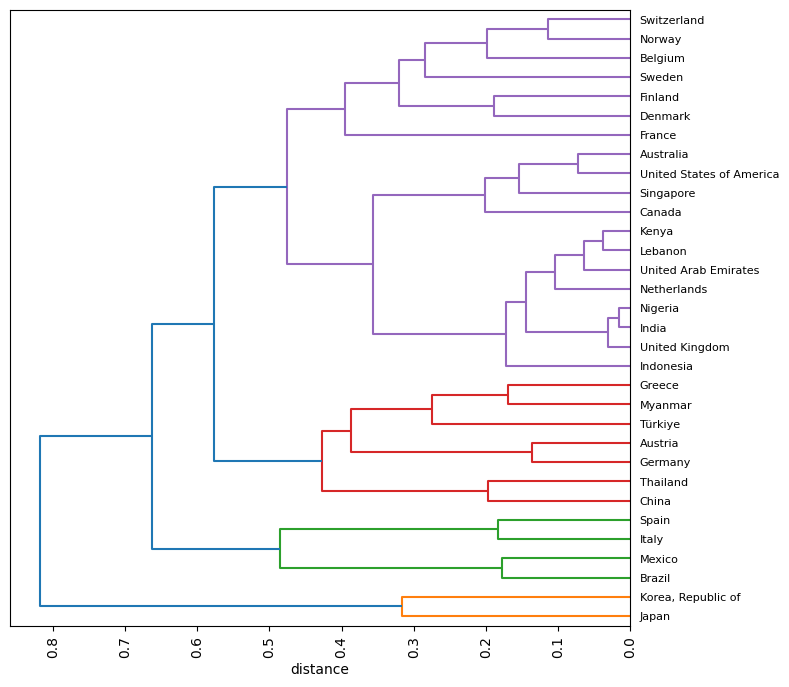

In [44]:
country_filter = country_topic_distribution["n_docs"] >= 50
linkage_matrix = linkage(country_topic_distribution[country_filter].filter(regex="topic_"),
    method="complete", metric="jensenshannon")
f = plt.figure(figsize=(8, 8))
dendrogram(linkage_matrix, labels=country_topic_distribution[country_filter]["country"].tolist(), orientation="left")
plt.xlabel("distance")
plt.xticks(rotation="vertical")
plt.show()